/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
neptune: Executing in Offline Mode.


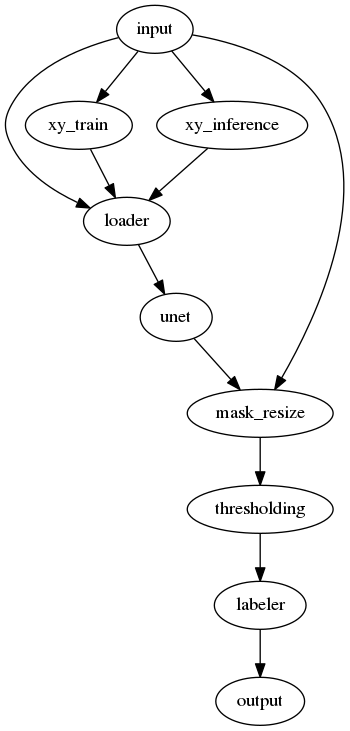

In [1]:
from pipelines import unet_multitask
from pipeline_config import SOLUTION_CONFIG

pipe = unet_multitask(SOLUTION_CONFIG, train_mode=True)
pipe

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

In [108]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei,file_path_centers,file_path_contours
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,27.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
1,003cee89357d9fe13516167fd67b609a164651b2193458...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,36.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,70.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,86.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,7.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...


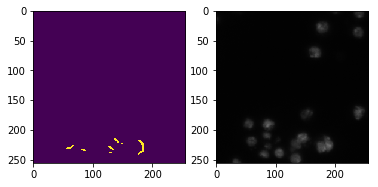

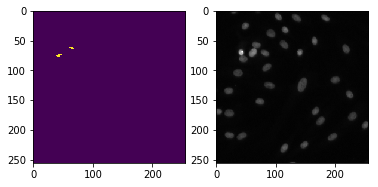

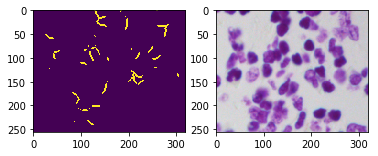

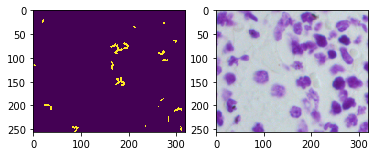

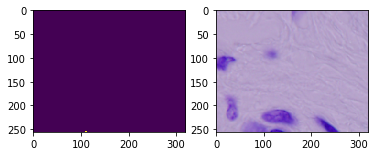

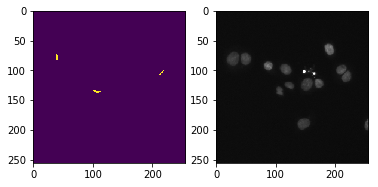

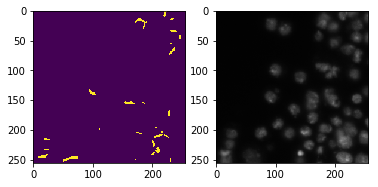

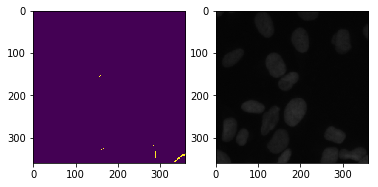

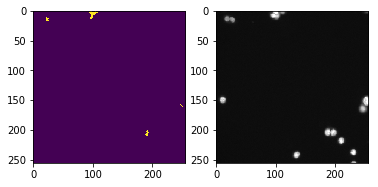

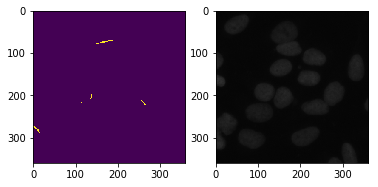

In [133]:
filepaths_c = meta['file_path_contours'].values
filepaths_r = meta['file_path_image'].values

for i in range(10):
    plt.subplot(121)
    img = plt.imread(filepaths_c[i])
    plt.imshow(img)
    plt.subplot(122)
    img = plt.imread(filepaths_r[i])
    plt.imshow(img)
    plt.show()

/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


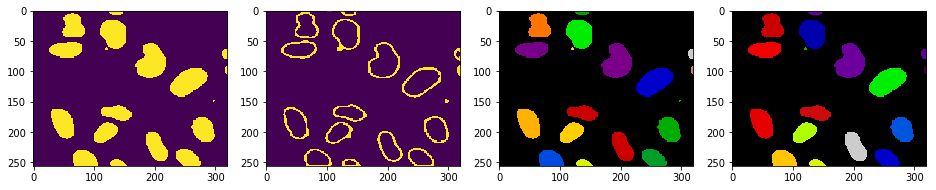

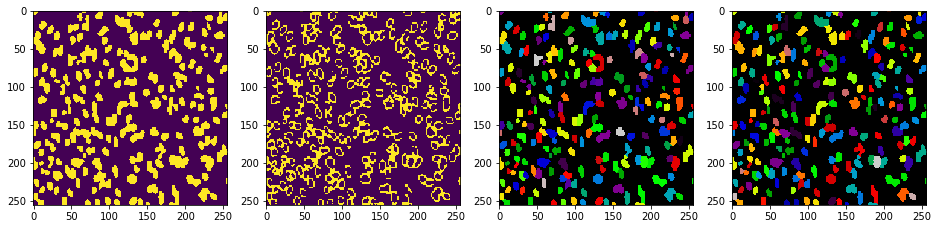

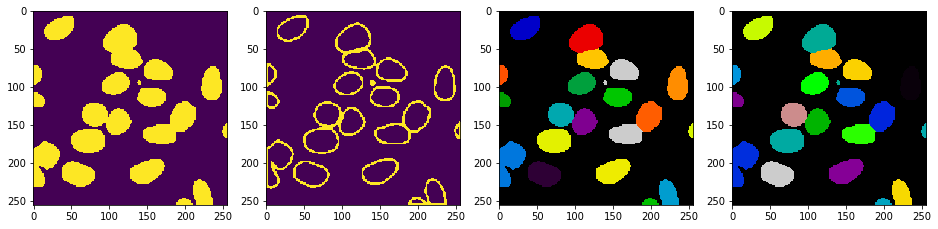

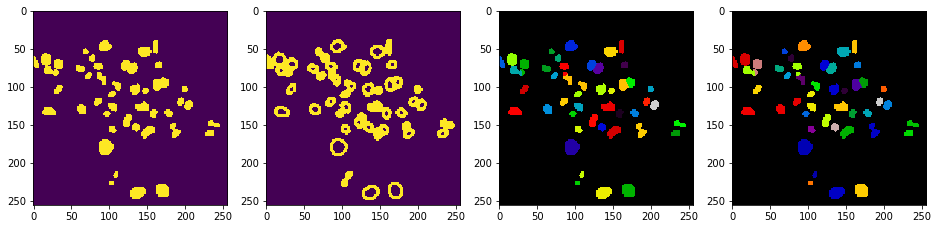

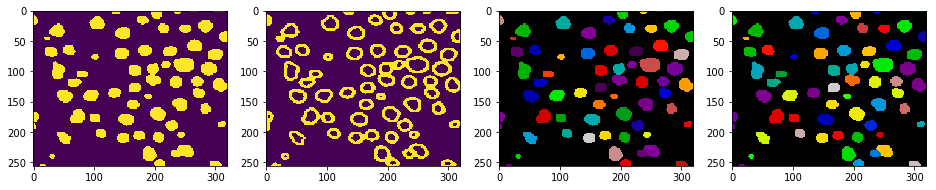

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from scipy.stats import itemfreq
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
watershed_contour = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/watershed_contour')
drop_smaller = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/drop_smaller')


for idx in np.random.choice(range(100),5):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    w = watershed_contour['detached_images'][idx]
    d = drop_smaller['labels'][idx]
    
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t) 
    plt.subplot(143)
    plt.imshow(random_colors(w),cmap='spectral')   
    plt.subplot(144)
    plt.imshow(random_colors(d),cmap='spectral')
    plt.show()


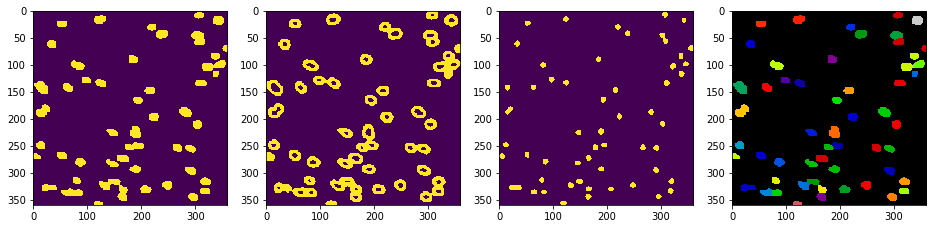

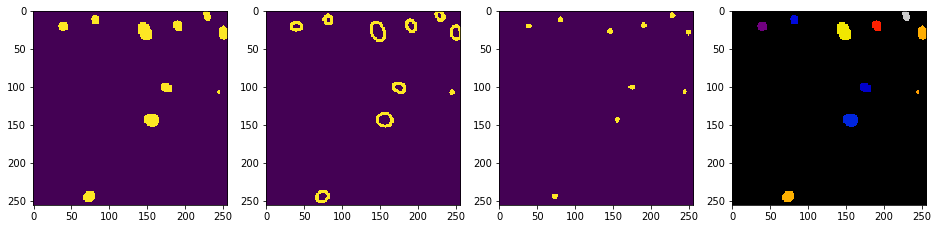

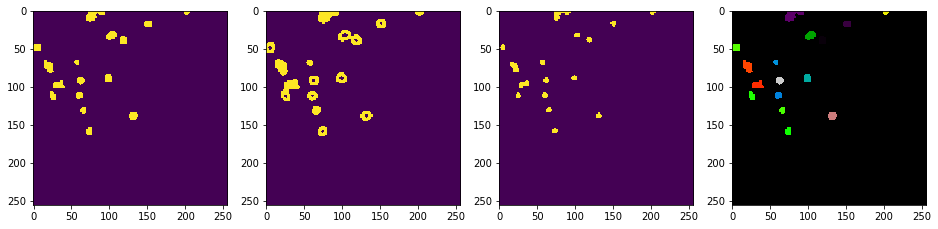

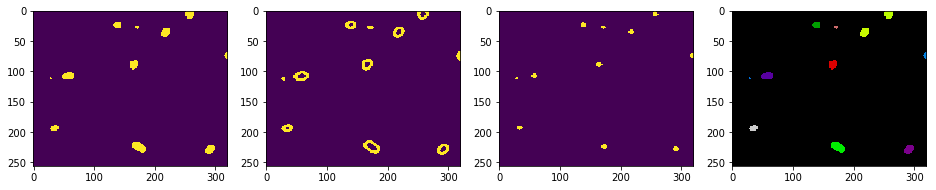

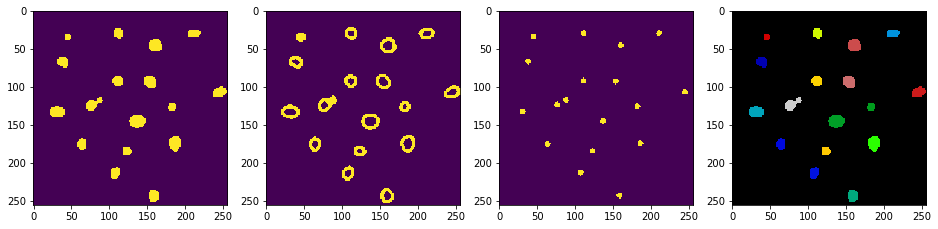

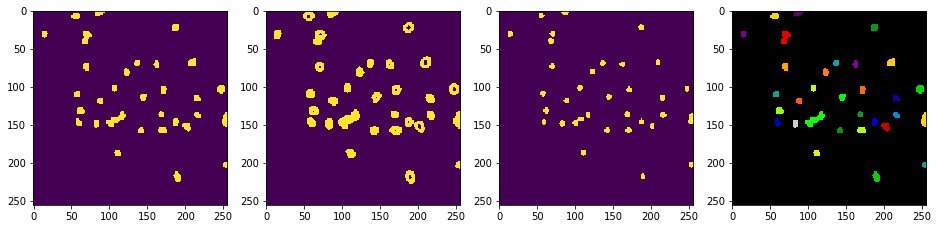

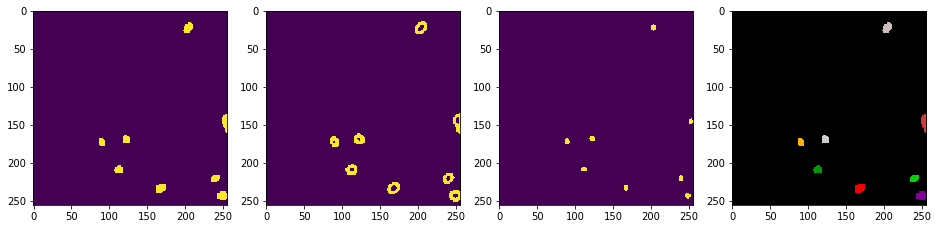

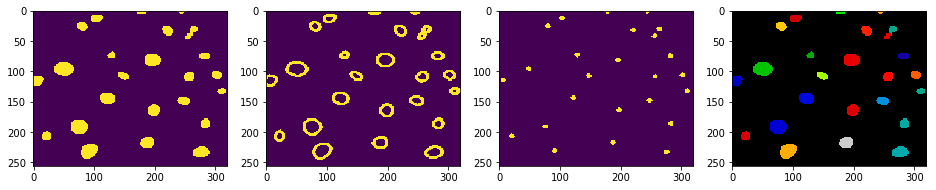

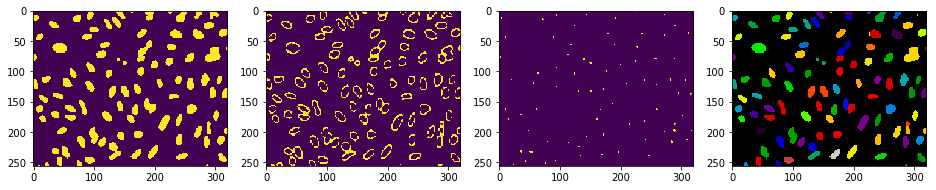

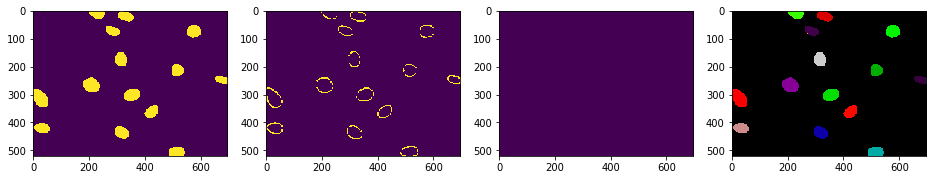

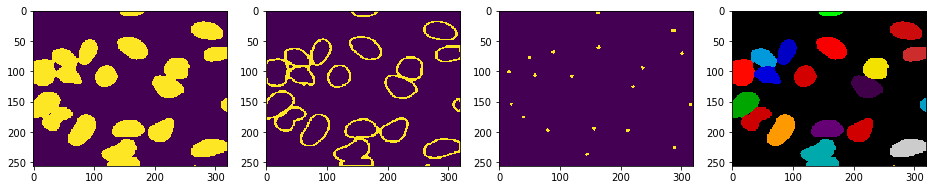

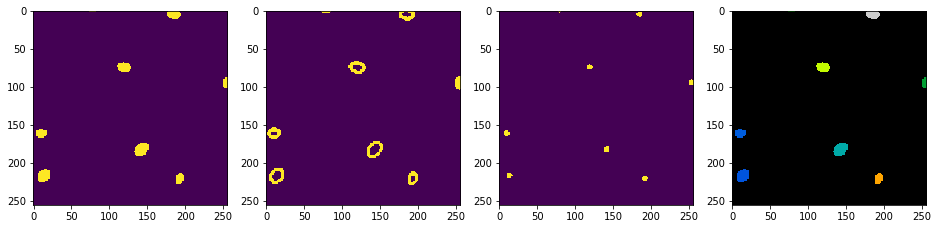

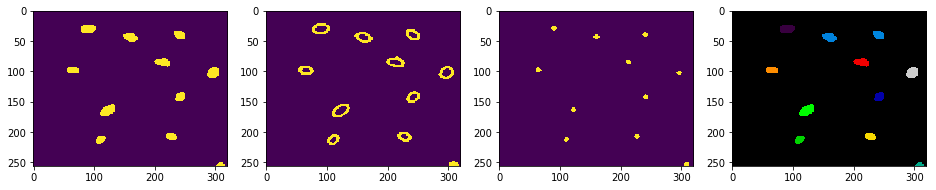

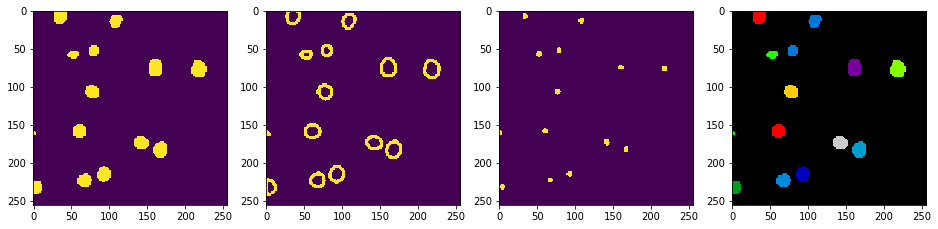

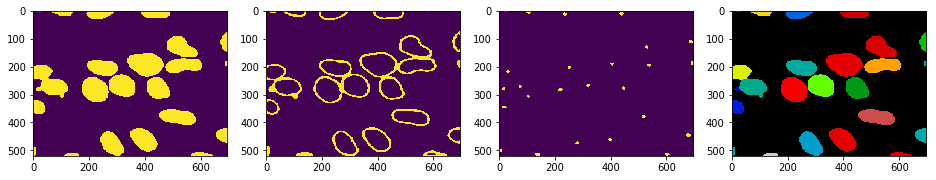

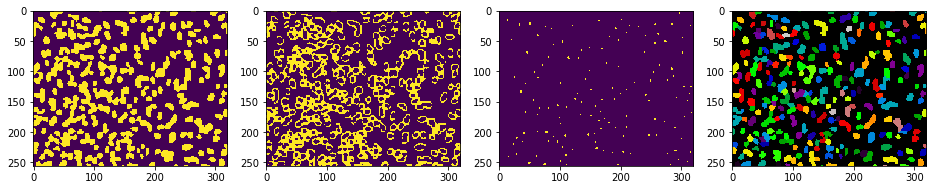

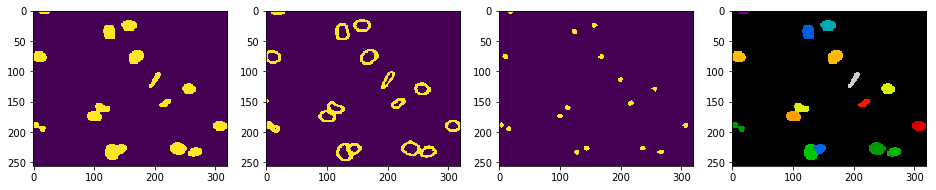

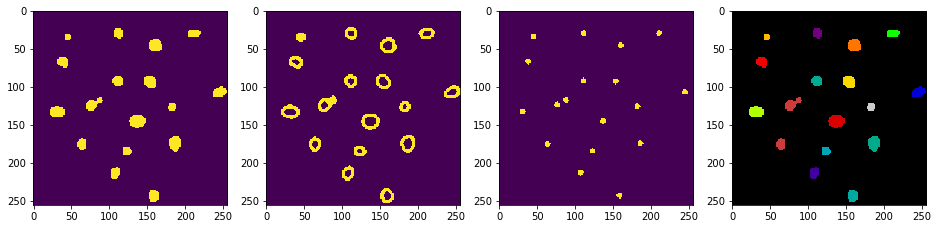

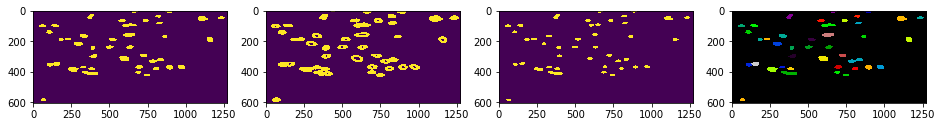

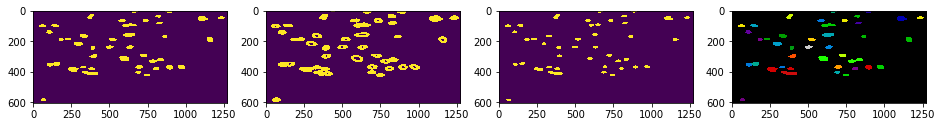

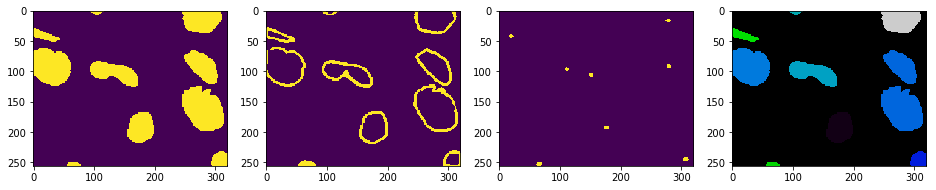

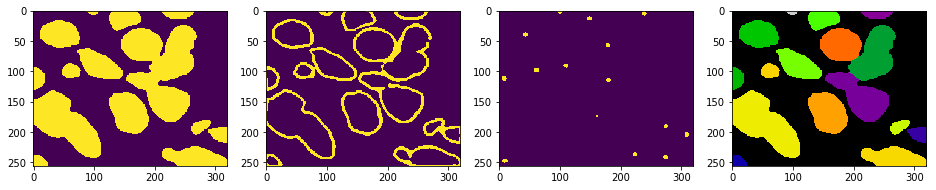

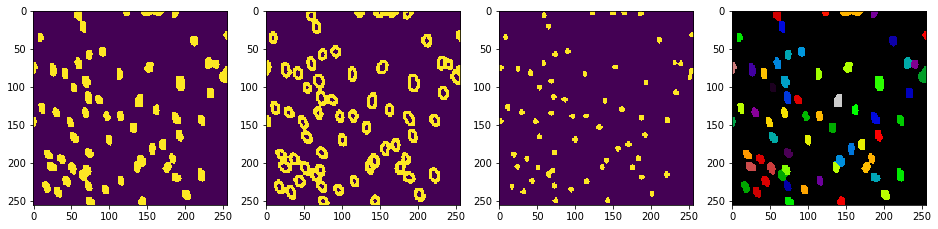

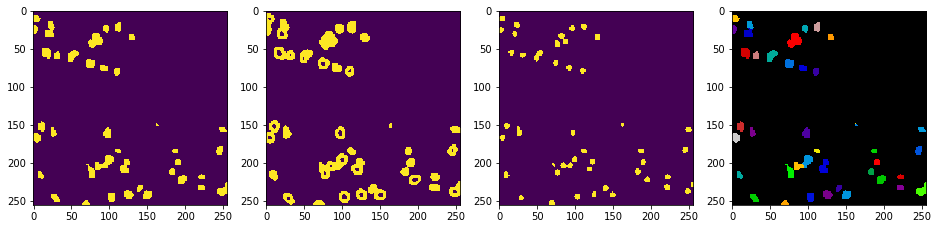

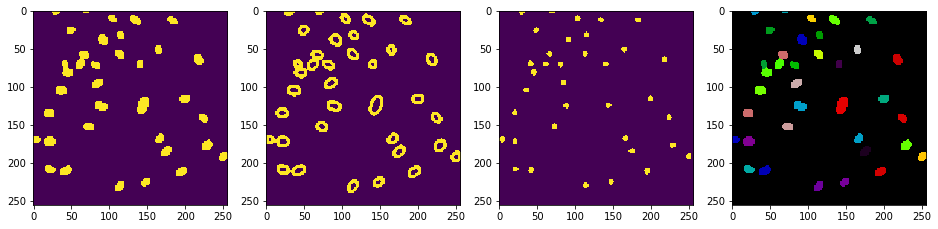

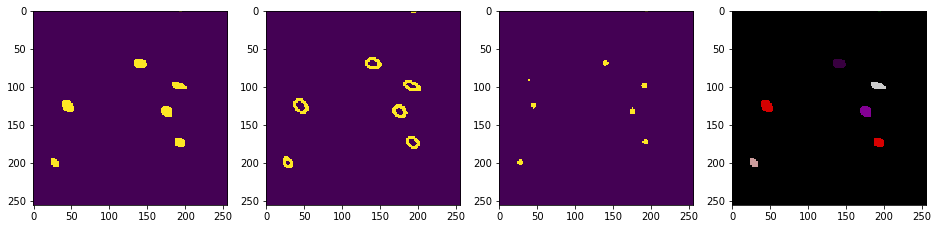

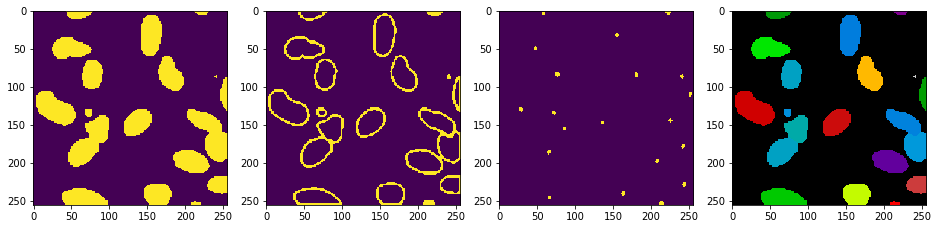

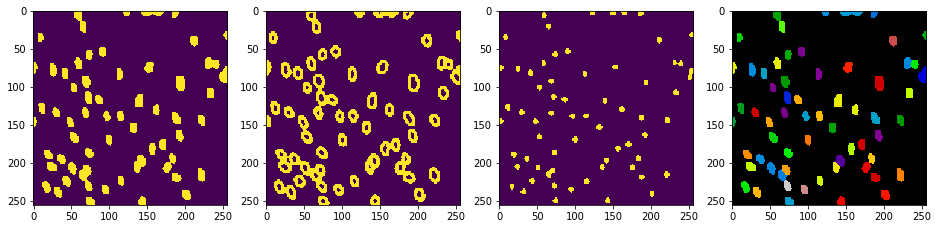

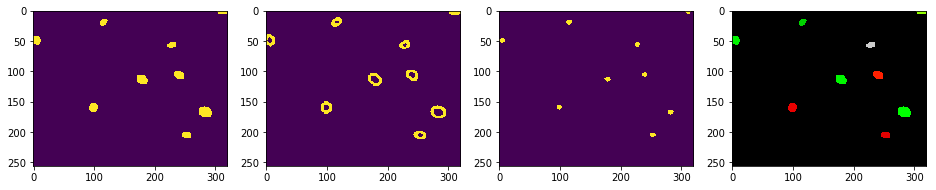

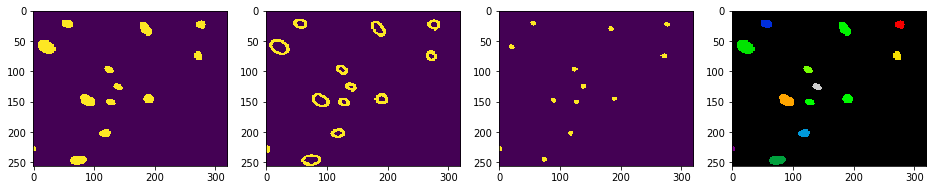

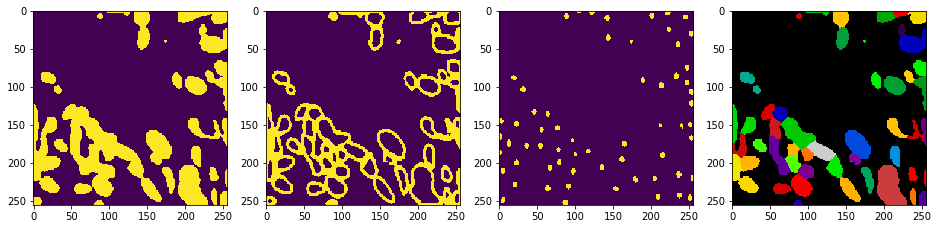

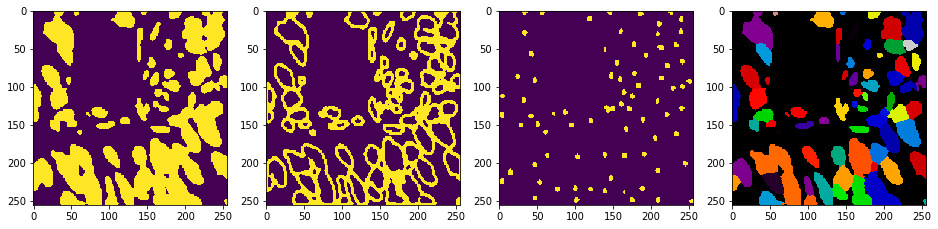

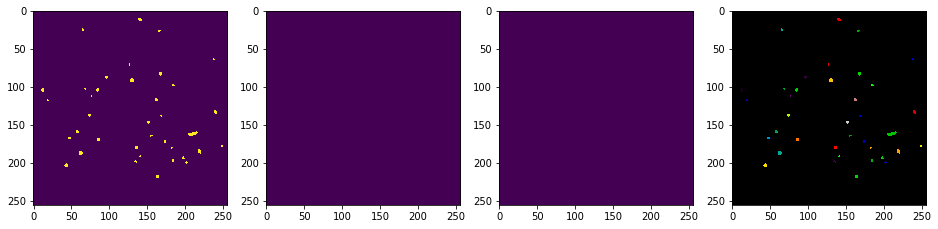

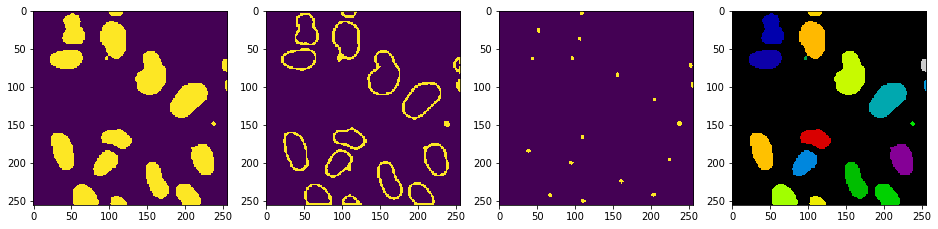

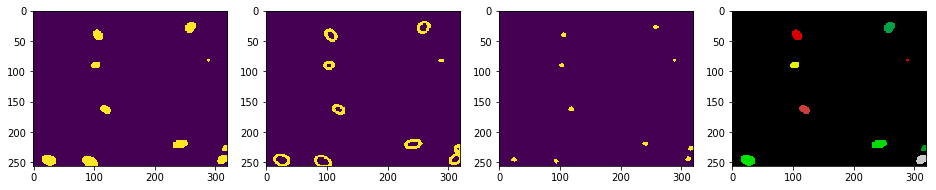

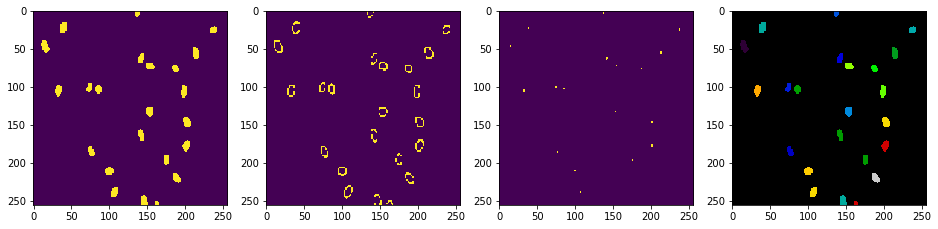

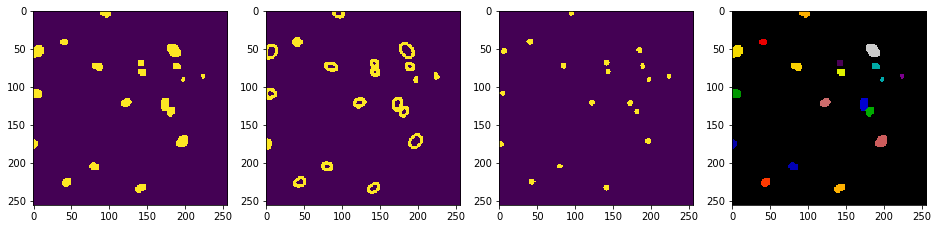

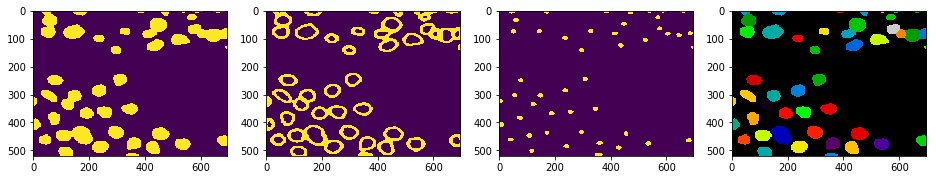

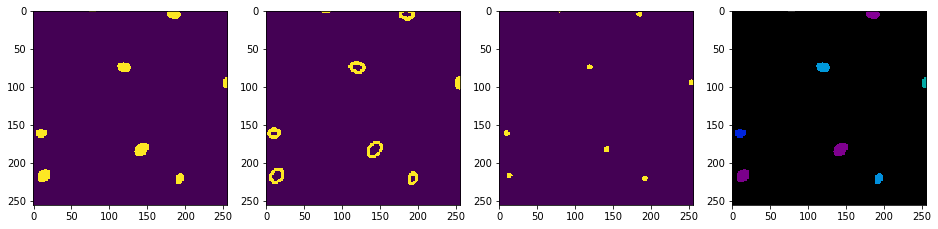

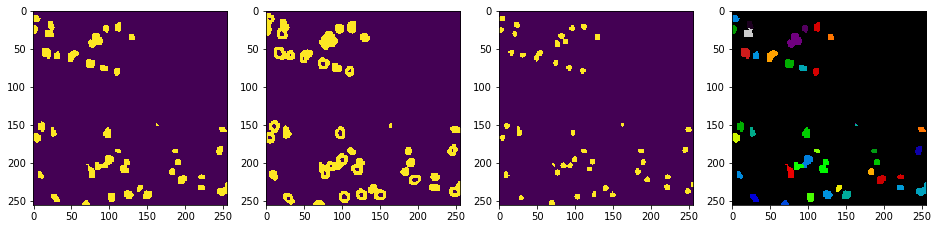

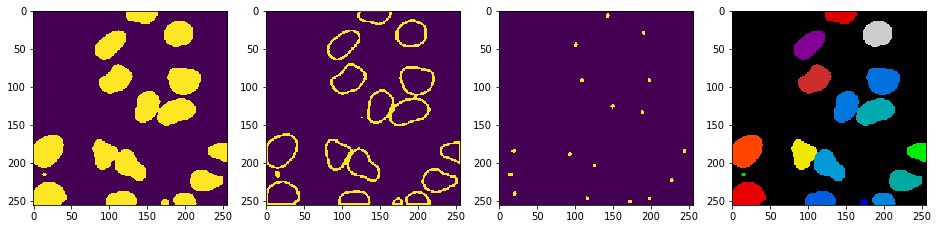

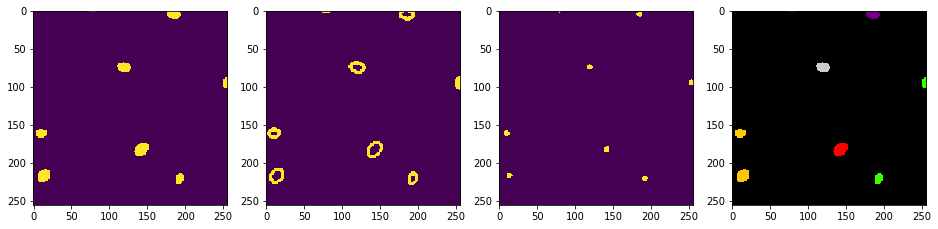

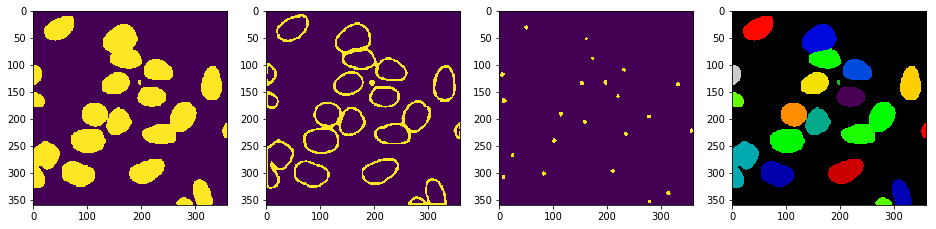

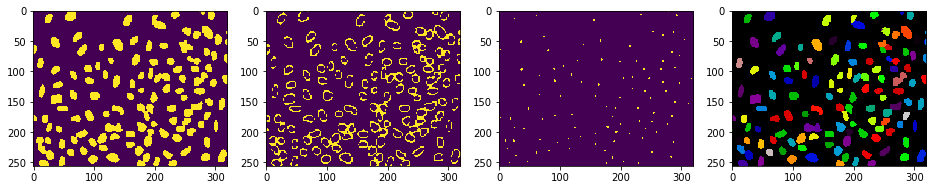

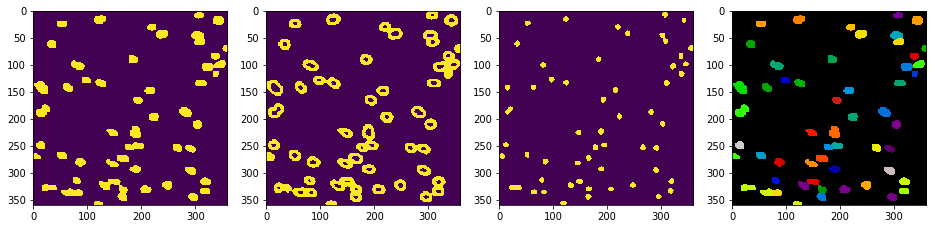

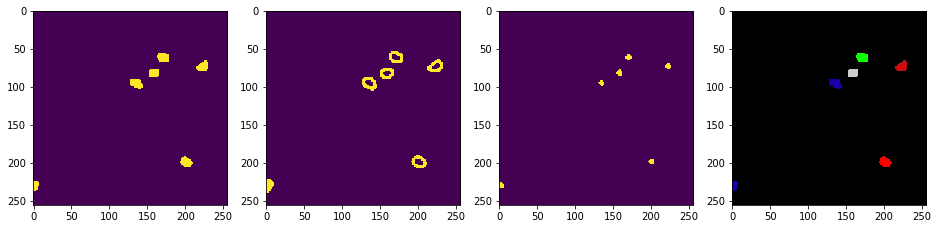

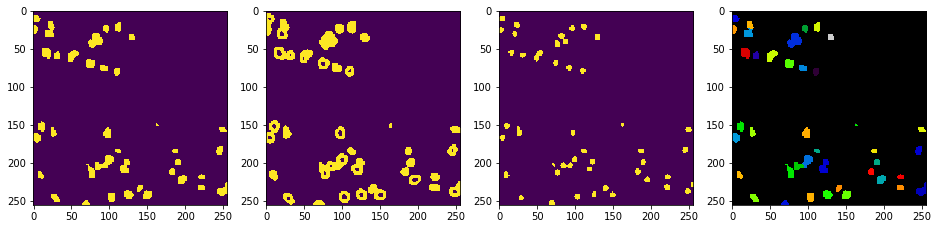

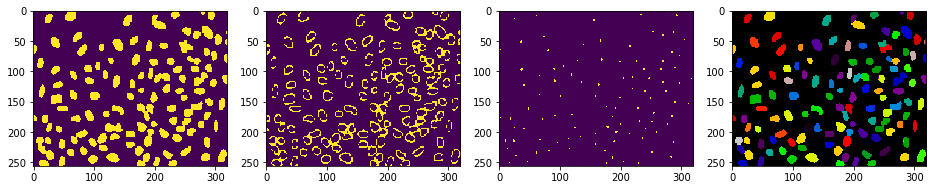

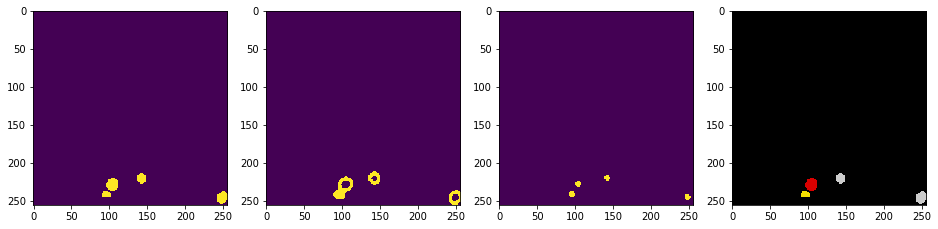

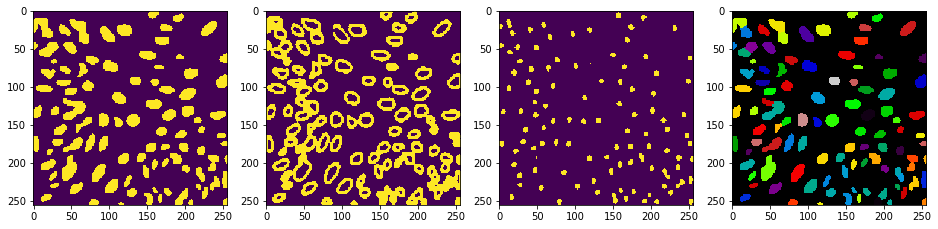

In [126]:
from tqdm import tqdm
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import itemfreq
from sklearn.externals import joblib
from skimage.transform import resize
import skimage.morphology as morph

from preparation import train_valid_split

def watershed_combined(image, contour, center):
    mask = np.where(contour + image == 2, 0, image)

    distance = ndi.distance_transform_edt(mask)
    markers, nr_blobs = ndi.label(mask)
    labeled = morph.watershed(-distance, markers, mask=image)

    dropped, _ = ndi.label(image - (labeled > 0))
    dropped = np.where(dropped > 0, dropped + nr_blobs, 0)
    correct_labeled = dropped + labeled

    return correct_labeled
    
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
center_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/center_thresholding')

for idx in np.random.choice(range(100),50):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    c = center_thresholding['binarized_images'][idx]
    wc = watershed_combined(m,t,c)
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t)
    plt.subplot(143)
    plt.imshow(c)   
    plt.subplot(144)
    plt.imshow(random_colors(wc),cmap='nipy_spectral') 
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

In [ ]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

In [ ]:
filepaths_c = meta['file_path_contours'].values
filepaths_r = meta['file_path_image'].values

for i in range(10):
    plt.subplot(121)
    img = plt.imread(filepaths_c[i])
    plt.imshow(img)
    plt.subplot(122)
    img = plt.imread(filepaths_r[i])
    plt.imshow(img)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from scipy.stats import itemfreq
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
watershed_contour = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/watershed_contour')
drop_smaller = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/drop_smaller')


for idx in np.random.choice(range(100),5):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    w = watershed_contour['detached_images'][idx]
    d = drop_smaller['labels'][idx]
    
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t) 
    plt.subplot(143)
    plt.imshow(random_colors(w),cmap='spectral')   
    plt.subplot(144)
    plt.imshow(random_colors(d),cmap='spectral')
    plt.show()


In [ ]:
from tqdm import tqdm
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import itemfreq
from sklearn.externals import joblib
from skimage.transform import resize
import skimage.morphology as morph

from preparation import train_valid_split

def watershed_combined(image, contour, center):
    mask = np.where(contour + image == 2, 0, image)

    distance = ndi.distance_transform_edt(mask)
    markers, nr_blobs = ndi.label(mask)
    labeled = morph.watershed(-distance, markers, mask=image)

    dropped, _ = ndi.label(image - (labeled > 0))
    dropped = np.where(dropped > 0, dropped + nr_blobs, 0)
    correct_labeled = dropped + labeled

    return correct_labeled
    
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
center_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/center_thresholding')

for idx in np.random.choice(range(100),50):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    c = center_thresholding['binarized_images'][idx]
    wc = watershed_combined(m,t,c)
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t)
    plt.subplot(143)
    plt.imshow(c)   
    plt.subplot(144)
    plt.imshow(random_colors(wc),cmap='nipy_spectral') 
    plt.show()

In [ ]:
?plt.imsave

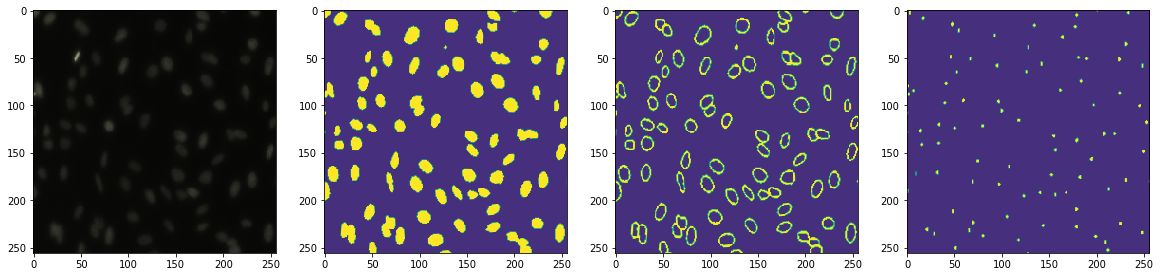

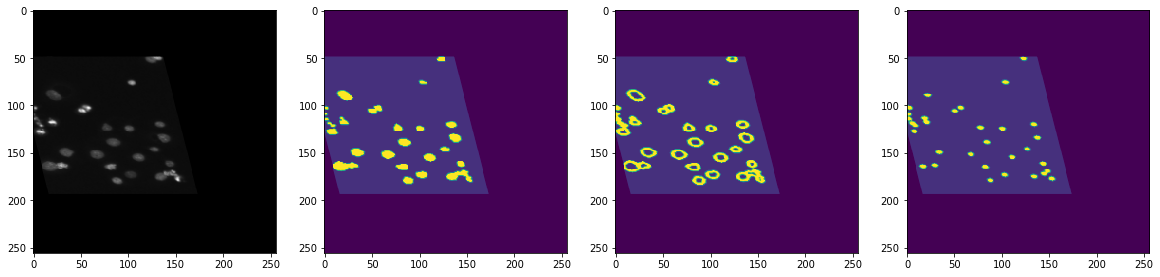

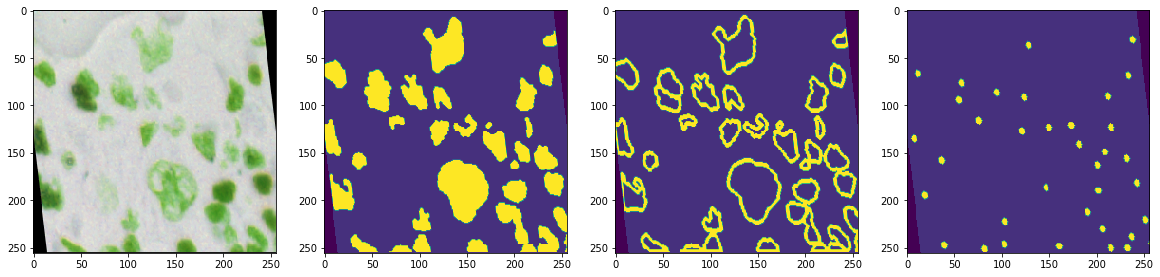

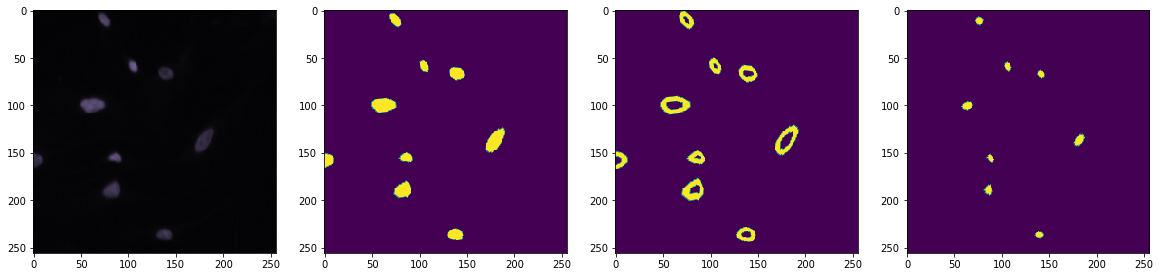

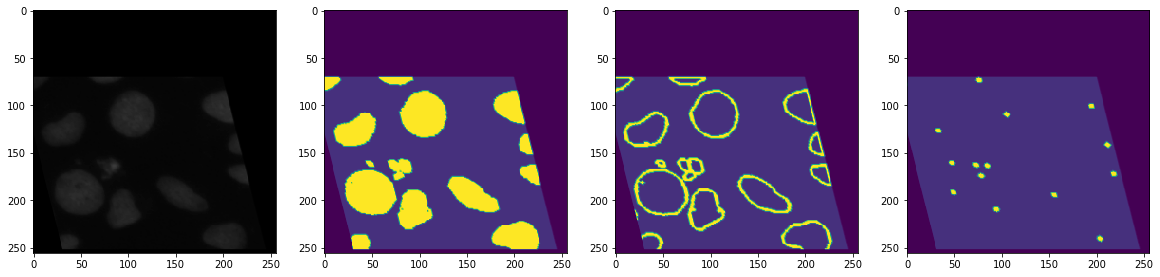

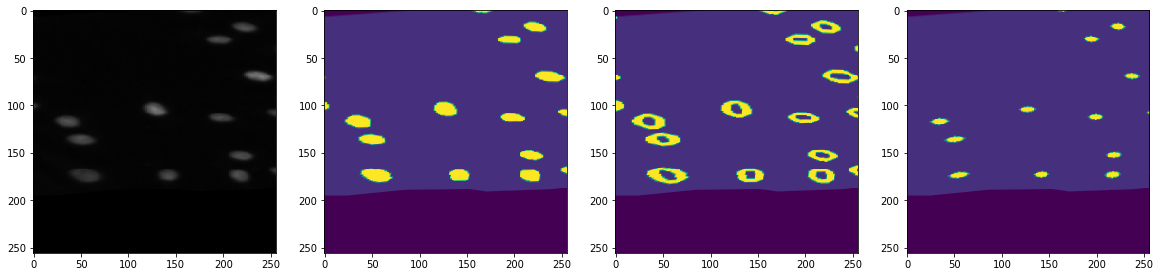

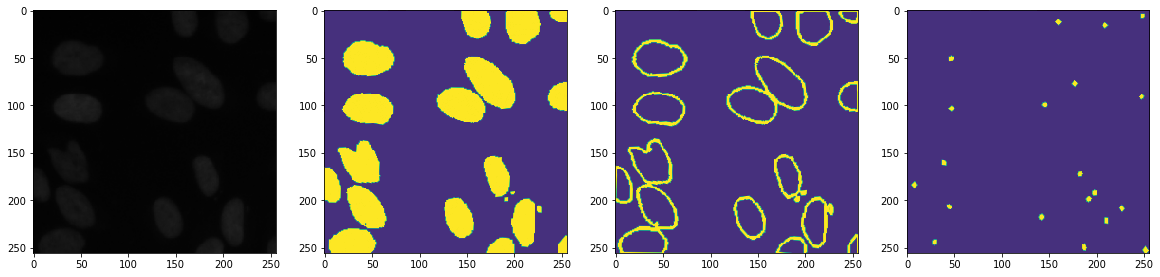

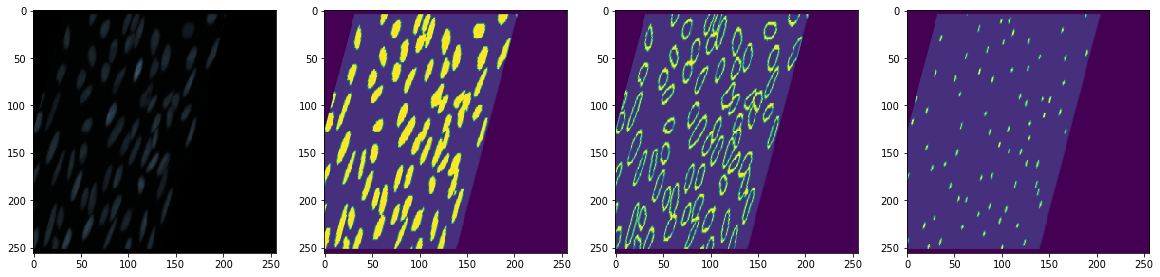

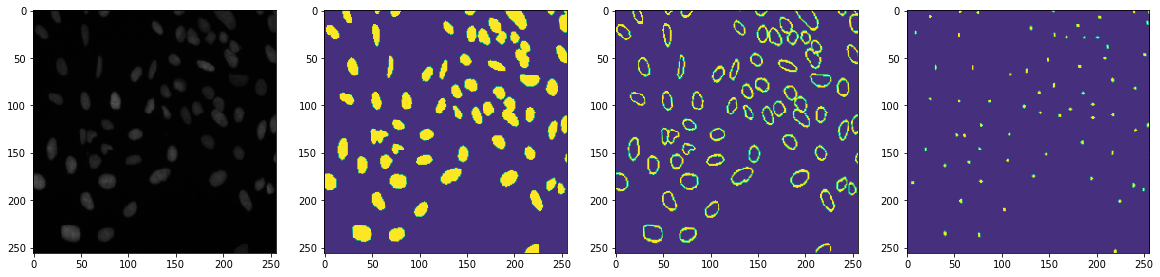

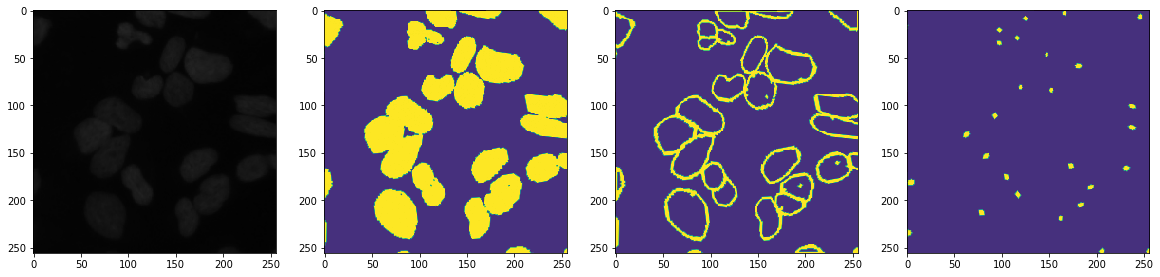

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    r = plt.imread( '/mnt/ml-team/minerva/debug/raw{}.jpg'.format(i))
    m = plt.imread( '/mnt/ml-team/minerva/debug/mask{}.jpg'.format(i))
    t = plt.imread( '/mnt/ml-team/minerva/debug/contour{}.jpg'.format(i))
    c = plt.imread( '/mnt/ml-team/minerva/debug/center{}.jpg'.format(i))
    plt.figure(figsize=(20,10))
    plt.subplot(141)
    plt.imshow(r)
    plt.subplot(142)
    plt.imshow(m)
    plt.subplot(143)
    plt.imshow(t)
    plt.subplot(144)
    plt.imshow(c)
    plt.show()

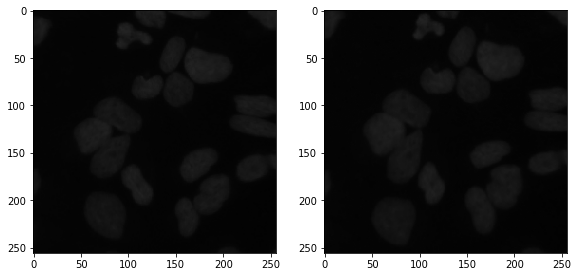

In [13]:
# from steps.pytorch.utils import ImgAug
from imgaug import augmenters as iaa

from augmentation import affine_seq
from utils import from_pil, to_pil

augmenter = iaa.PiecewiseAffine(scale=(0.01, 0.05))


plt.figure(figsize=(20,10))
plt.subplot(143)
plt.imshow(r)
plt.subplot(144)
plt.imshow(augmenter.augment_image(r))
plt.show()


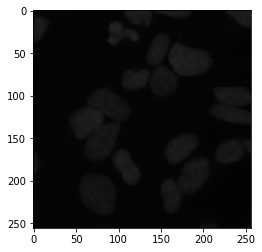

In [3]:
plt.imshow(r)

In [ ]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

In [ ]:
meta_train = meta[meta['is_train']==1]

# K-means clustering of images

In [5]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta_train = meta[meta['is_train']==1]
meta_train.head()

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei,file_path_centers,file_path_contours,vgg_features_clusters
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,27.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,4.0
1,003cee89357d9fe13516167fd67b609a164651b2193458...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,36.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,4.0
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,70.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,5.0
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,86.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,5.0
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,7.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,5.0


In [6]:
meta_train['vgg_features_clusters'].value_counts()

9.0    111
4.0    109
7.0     96
6.0     93
2.0     56
1.0     54
3.0     54
5.0     53
0.0     30
8.0     14
Name: vgg_features_clusters, dtype: int64

In [11]:
import ipywidgets as ipy
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
@ipy.interact(k=ipy.IntSlider(min=0,max=10,value=0,step=1))
def plot(k):
    cluster1 = meta_train[meta_train['vgg_features_clusters']==k]
    random_paths = cluster1.sample(n)['file_path_image'].values

    plt.figure(figsize=(16,12))
    for i,p in enumerate(random_paths):
        plt.subplot(2,n/2.,i+1)
        img = plt.imread(p)
        plt.imshow(img)
    plt.show()

interactive(children=(IntSlider(value=0, description='k', max=10), Output()), _dom_classes=('widget-interact',))

https://surabhibhargava.github.io/Detection-and-Segmentation-of-Nuclei-in-Computational-Pathology/
    
    
    
http://openaccess.thecvf.com/content_ICCV_2017/papers/Liu_SGN_Sequential_Grouping_ICCV_2017_paper.pdf

http://www.bioimageanalysis.org/wp/wp-content/uploads/formidable/6/MIMO-Net_Isbi2017.pdf

https://arxiv.org/pdf/1607.04889.pdf

https://www.researchgate.net/profile/Yizhe_Zhang13/publication/319460791_Deep_Adversarial_Networks_for_Biomedical_Image_Segmentation_Utilizing_Unannotated_Images/links/59c9163fa6fdccc71929d61b/Deep-Adversarial-Networks-for-Biomedical-Image-Segmentation-Utilizing-Unannotated-Images.pdf